<center>
    <h1>Time Series Forecasting of JPMorgan Data</h1>
    <h3>Name: Prerak Shah, Sai Sri Meghana Dharmapuri</h3>
</center>

# 1. Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [2]:
df_stock = pd.read_csv('JPM.csv')

In [3]:
df_stock.shape

(9745, 7)

In [4]:
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,5.018518,5.129630,5.018518,5.037037,0.304709,62400
1,1980-03-18,5.037037,5.111111,5.037037,5.074074,0.306950,63900
2,1980-03-19,5.111111,5.166667,5.111111,5.148148,0.311431,40500
3,1980-03-20,5.148148,5.148148,5.092593,5.111111,0.309190,18900
4,1980-03-21,5.111111,5.222222,5.111111,5.222222,0.315912,97200


# Data Cleaning 

# 2. Drop Date and Adj_Close columns

In [5]:
# storing the original dataset in a different dataframe before dropping the columns 
df_stock_new = df_stock
df_stock_new.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,5.018518,5.129630,5.018518,5.037037,0.304709,62400
1,1980-03-18,5.037037,5.111111,5.037037,5.074074,0.306950,63900
2,1980-03-19,5.111111,5.166667,5.111111,5.148148,0.311431,40500
3,1980-03-20,5.148148,5.148148,5.092593,5.111111,0.309190,18900
4,1980-03-21,5.111111,5.222222,5.111111,5.222222,0.315912,97200


In [6]:
# dropping the columns Date and Adj_Close
df_stock_new=df_stock_new.drop(['Date', 'Adj Close'], axis=1)
df_stock_new.head()
#df_stock_new.['y'] = df_stock_new.['Close']

,Open,High,Low,Close,Volume
0,5.018518,5.129630,5.018518,5.037037,62400
1,5.037037,5.111111,5.037037,5.074074,63900
2,5.111111,5.166667,5.111111,5.148148,40500
3,5.148148,5.148148,5.092593,5.111111,18900
4,5.111111,5.222222,5.111111,5.222222,97200


In [7]:
df_stock_new.shape

(9745, 5)

In [8]:
df_stock.shape

(9745, 7)

# 3. Removing null values 

In [9]:
df_stock_new.shape

(9745, 5)

In [10]:
#Calling sum() of the DataFrame returned by isnull() will give a series containing data about count of NaN in each column
df_stock_new.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [11]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']

In [12]:
df_stock_new.head()

,Open,High,Low,Close,Volume,y
0,5.018518,5.129630,5.018518,5.037037,62400,5.037037
1,5.037037,5.111111,5.037037,5.074074,63900,5.074074
2,5.111111,5.166667,5.111111,5.148148,40500,5.148148
3,5.148148,5.148148,5.092593,5.111111,18900,5.111111
4,5.111111,5.222222,5.111111,5.222222,97200,5.222222


# 4. Normalizing the columns 

In [13]:
#Normalizing the training numeric values using zscore
from scipy.stats import zscore
df_stock_new['Open'] = zscore(df_stock_new['Open'])
df_stock_new['High'] = zscore(df_stock_new['High'])
df_stock_new['Low'] = zscore(df_stock_new['Low'])
df_stock_new['Close'] = zscore(df_stock_new['Close'])
df_stock_new['Volume'] = zscore(df_stock_new['Volume'])

In [14]:
x=df_stock_new.as_matrix(columns=['Open','High','Low','Volume','Close'])

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [15]:
x.shape

(9745, 5)

In [16]:
df_stock_new.shape

(9745, 6)

In [17]:
#y=df_stock_new.as_matrix(['y'])

In [18]:
y=df_stock_new['y'].tolist()

In [19]:
y=np.array(y)

In [20]:
y.shape

(9745,)

# 4. Data Transformation

In [21]:
import numpy as np

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [22]:
SEQUENCE_SIZE = 1
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))

Shape of x_seq: (9744, 1, 1, 5)
Shape of y_seq: (9744,)


In [23]:
x_seq_2d = x_seq.reshape(9744,5)    

# 6. Splitting the dataset into test and train data ( 70% train & 30% test )

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_seq,test_size=0.30,random_state=0)

In [25]:
X_train.shape

(6820, 5)

In [26]:
X_test.shape

(2924, 5)

In [27]:
Y_train.shape

(6820,)

In [28]:
Y_test.shape

(2924,)

In [29]:
type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

numpy.ndarray

# 7. Applying Neural networks

<h3>Dense layers: 64,32,32,1<h3>

In [30]:
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers




Model trained for "adam" optimizer and "relu" activation function : 

Train on 6820 samples, validate on 2924 samples
Epoch 1/200
6820/6820 - 2s - loss: 524.2639 - val_loss: 46.0089
Epoch 2/200
6820/6820 - 1s - loss: 11.5250 - val_loss: 2.2568
Epoch 3/200
6820/6820 - 1s - loss: 1.6891 - val_loss: 1.2109
Epoch 4/200
6820/6820 - 1s - loss: 1.1133 - val_loss: 0.9342
Epoch 5/200
6820/6820 - 1s - loss: 0.8989 - val_loss: 0.7628
Epoch 6/200
6820/6820 - 1s - loss: 0.7898 - val_loss: 0.7050
Epoch 7/200
6820/6820 - 1s - loss: 0.7395 - val_loss: 0.6940
Epoch 8/200
6820/6820 - 1s - loss: 0.7674 - val_loss: 0.7056
Epoch 9/200
6820/6820 - 1s - loss: 0.7161 - val_loss: 0.7305
Epoch 10/200
6820/6820 - 1s - loss: 0.7290 - val_loss: 0.6808
Epoch 11/200
6820/6820 - 1s - loss: 0.6984 - val_loss: 0.6543
Epoch 12/200
6820/6820 - 1s - loss: 0.6900 - val_loss: 0.6549
Epoch 13/200
6820/6820 - 1s - loss: 0.6832 - val_loss: 0.6288
Epoch 14/200
6820/6820 - 1s - loss: 0.7025 - val_loss: 0.7293
Epoch 15/200
682

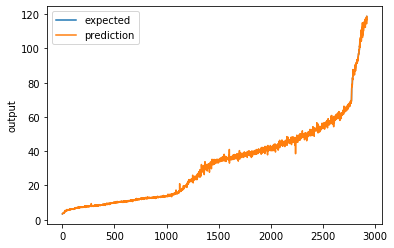




Model trained for "adam" optimizer and "sigmoid" activation function : 

Train on 6820 samples, validate on 2924 samples
Epoch 1/200
6820/6820 - 2s - loss: 1303.0708 - val_loss: 1117.2065
Epoch 2/200
6820/6820 - 1s - loss: 1013.3423 - val_loss: 918.8614
Epoch 3/200
6820/6820 - 1s - loss: 844.1865 - val_loss: 773.3500
Epoch 4/200
6820/6820 - 1s - loss: 727.3126 - val_loss: 681.6904
Epoch 5/200
6820/6820 - 1s - loss: 654.5015 - val_loss: 624.7192
Epoch 6/200
6820/6820 - 1s - loss: 598.2977 - val_loss: 510.3918
Epoch 7/200
6820/6820 - 1s - loss: 442.7222 - val_loss: 390.5251
Epoch 8/200
6820/6820 - 1s - loss: 359.5644 - val_loss: 323.9894
Epoch 9/200
6820/6820 - 1s - loss: 304.1578 - val_loss: 277.0720
Epoch 10/200
6820/6820 - 1s - loss: 261.2294 - val_loss: 237.3722
Epoch 11/200
6820/6820 - 1s - loss: 225.9230 - val_loss: 206.1594
Epoch 12/200
6820/6820 - 1s - loss: 197.7887 - val_loss: 180.6886
Epoch 13/200
6820/6820 - 1s - loss: 174.9124 - val_loss: 159.7590
Epoch 14/200
6820/6820 -

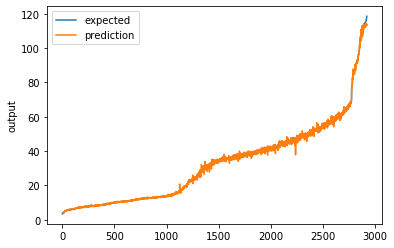




Model trained for "adam" optimizer and "tanh" activation function : 

Train on 6820 samples, validate on 2924 samples
Epoch 1/200
6820/6820 - 2s - loss: 1176.1647 - val_loss: 864.5745
Epoch 2/200
6820/6820 - 1s - loss: 742.2715 - val_loss: 630.5285
Epoch 3/200
6820/6820 - 1s - loss: 550.9290 - val_loss: 472.3813
Epoch 4/200
6820/6820 - 1s - loss: 418.6171 - val_loss: 363.6086
Epoch 5/200
6820/6820 - 1s - loss: 329.1540 - val_loss: 289.8310
Epoch 6/200
6820/6820 - 1s - loss: 267.2831 - val_loss: 237.7305
Epoch 7/200
6820/6820 - 1s - loss: 222.1891 - val_loss: 198.8757
Epoch 8/200
6820/6820 - 1s - loss: 188.3679 - val_loss: 168.9996
Epoch 9/200
6820/6820 - 1s - loss: 161.8190 - val_loss: 145.4175
Epoch 10/200
6820/6820 - 1s - loss: 140.5423 - val_loss: 126.3686
Epoch 11/200
6820/6820 - 1s - loss: 122.7146 - val_loss: 110.1756
Epoch 12/200
6820/6820 - 1s - loss: 107.7361 - val_loss: 96.8179
Epoch 13/200
6820/6820 - 1s - loss: 95.0008 - val_loss: 85.2614
Epoch 14/200
6820/6820 - 1s - lo

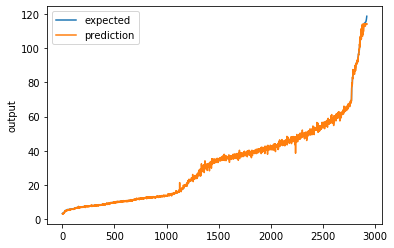




Model trained for "sgd" optimizer and "relu" activation function : 

Train on 6820 samples, validate on 2924 samples
Epoch 1/200
6820/6820 - 1s - loss: nan - val_loss: nan


C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/200
6820/6820 - 1s - loss: nan - val_loss: nan
Epoch 3/200
6820/6820 - 1s - loss: nan - val_loss: nan
Epoch 4/200
6820/6820 - 1s - loss: nan - val_loss: nan
Epoch 5/200
6820/6820 - 1s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 36967.44548911431
Final score (RMSE): 192.26920057334797


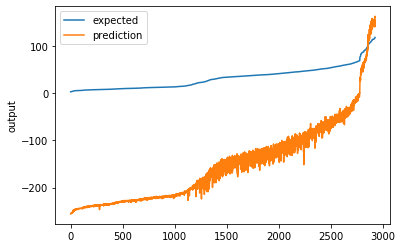




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Train on 6820 samples, validate on 2924 samples
Epoch 1/200
6820/6820 - 1s - loss: 111.2443 - val_loss: 6.9273
Epoch 2/200
6820/6820 - 1s - loss: 6.5348 - val_loss: 23.1414
Epoch 3/200
6820/6820 - 1s - loss: 4.1730 - val_loss: 4.4976
Epoch 4/200
6820/6820 - 1s - loss: 3.9641 - val_loss: 3.7052
Epoch 5/200
6820/6820 - 1s - loss: 3.6854 - val_loss: 3.2723
Epoch 6/200
6820/6820 - 1s - loss: 2.2239 - val_loss: 3.1040
Epoch 7/200
6820/6820 - 1s - loss: 1.8838 - val_loss: 5.4526
Epoch 8/200
6820/6820 - 1s - loss: 2.3529 - val_loss: 2.1811
Epoch 9/200
6820/6820 - 1s - loss: 1.2832 - val_loss: 1.5682
Epoch 10/200
6820/6820 - 1s - loss: 1.5886 - val_loss: 3.4081
Epoch 11/200
6820/6820 - 1s - loss: 1.9578 - val_loss: 1.1597
Epoch 12/200
6820/6820 - 1s - loss: 1.2451 - val_loss: 5.2275
Epoch 13/200
6820/6820 - 1s - loss: 1.3180 - val_loss: 0.9834
Epoch 14/200
6820/6820 - 1s - loss: 1.4962 - val_loss: 3.8250
Epoch 15/200
68

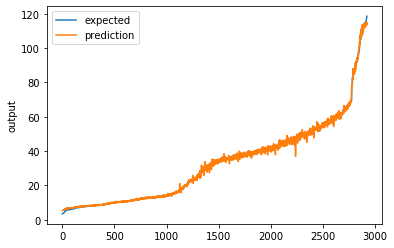




Model trained for "sgd" optimizer and "tanh" activation function : 

Train on 6820 samples, validate on 2924 samples
Epoch 1/200
6820/6820 - 1s - loss: 128.6981 - val_loss: 7.9913
Epoch 2/200
6820/6820 - 1s - loss: 12.5329 - val_loss: 392.6491
Epoch 3/200
6820/6820 - 1s - loss: 13.4046 - val_loss: 6.3032
Epoch 4/200
6820/6820 - 1s - loss: 8.8576 - val_loss: 31.1027
Epoch 5/200
6820/6820 - 1s - loss: 11.5976 - val_loss: 4.6356
Epoch 6/200
6820/6820 - 1s - loss: 4.2509 - val_loss: 18.7184
Epoch 7/200
6820/6820 - 1s - loss: 4.8297 - val_loss: 34.6209
Epoch 8/200
6820/6820 - 1s - loss: 10.6975 - val_loss: 76.8228
Epoch 9/200
6820/6820 - 1s - loss: 54.8022 - val_loss: 57.3436
Epoch 10/200
6820/6820 - 1s - loss: 19.2755 - val_loss: 13.2862
Epoch 00010: early stopping


Final score (MSE): 4.6355558630154805
Final score (RMSE): 2.153034106328899


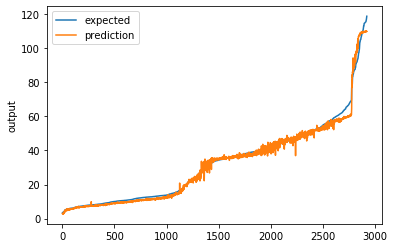

In [31]:
optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:

        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        
        model = Sequential()
        model.add(Dense(64, input_dim=X_train.shape[1], activation=act))
        model.add(Dense(32,activation=act))
        model.add(Dense(32,activation=act))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=opt)

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

        model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)

        model.load_weights('best_weights_NN.hdf5')
        
        pred = model.predict(X_test)
        
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,Y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
        print("Final score (RMSE): {}".format(rmse))
        
        chart_regression(pred.flatten(),Y_test,sort=True)